# R Aquilae: model 1 cont
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch.nn          as nn
import torch

from torch.optim          import Adam
from tqdm                 import tqdm
from astropy              import units, constants
from ipywidgets           import interact

from pomme.utils       import convert_angular_to_spatial
from pomme.plot        import plot_cube_2D, plot_spectrum
from pomme.object      import AstroObject
from pomme.observation import DataCube, Beam

from pomme.model       import TensorModel, SphericallySymmetric
from pomme.utils       import print_var, interpolate, convert_angular_to_spatial
from pomme.lines       import Line
from pomme.loss        import Loss, diff_loss, steady_state_continuity_loss

In [2]:
obj = AstroObject('R Aql')

Using the parallax distance.


In [3]:
obs   = torch.from_numpy(np.load('obs_CO_J=2-1_res=100x100x29.npy'))
freqs = torch.from_numpy(np.load('frq_CO_J=2-1_res=100x100x29.npy'))

In [4]:
model = TensorModel.load('tm_R_Aql_base_res=100.h5')

In [5]:
def analytic_velo(r, r_in, v_in, v_inf, beta):
    return v_in + (v_inf - v_in) * (1.0 - r_in / r)**beta


def analytic_T(r, r_in, T_in, epsilon):
    return T_in * (r_in / r)**epsilon

In [6]:
r_x, r_y, r_z = model.get_radial_direction(origin='centre')
r             = model.get_radius          (origin='centre')
d = r / r.min()

model['log_CO'          ] = np.log(5.0e+9 * (1.0/d)**2)
model['log_v_in'        ] = np.log(1.0e+1)
model['log_v_inf'       ] = np.log(1.0e+4)
model['beta'            ] = 1.0
model['log_T_in'        ] = np.log(5.0e+3)
model['log_epsilon'     ] = np.log(0.5)
model['log_v_turbulence'] = np.log(1.5e+2) * np.ones(model.shape)

loss = Loss(['rep', 'nrm_rep', 'reg', 'cnt'])

model.fix_all()
model.free('log_CO')
model.free('log_v_in')
# model.free('log_v_inf')
model.free('beta')
model.free('log_T_in')
model.free('log_epsilon')

model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_CO                     Free          True     +1.314e+01     +1.441e+01     +2.233e+01
  log_v_in                   Free          False    +2.303e+00     +2.303e+00     +2.303e+00
  log_v_inf                  Fixed         False    +9.210e+00     +9.210e+00     +9.210e+00
  beta                       Free          False    +1.000e+00     +1.000e+00     +1.000e+00
  log_T_in                   Free          False    +8.517e+00     +8.517e+00     +8.517e+00
  log_epsilon                Free          False    -6.931e-01     -6.931e-01     -6.931e-01
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
sizes: [5.59518907e+14 5.59518907e+14 5.59518907e+14]
shape: (100, 100, 100)


In [7]:
line = Line('CO', 1)

You have selected line:
    CO(J=2-1)
Please check the properties that were inferred:
    Frequency         2.305380000e+11  Hz
    Einstein A coeff  6.910000000e-07  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [8]:
spatial_average = obs.sum(axis=(0,1))
line_centre     = freqs[np.where(spatial_average==spatial_average.max())[0][0]].item()
line_centre

230502373528.7

In [9]:
v_rad = (line_centre - line.frequency) / line.frequency * constants.c.si.value
v_rad

-46328.79352163112

In [10]:
velos = (1.0 - freqs / line.frequency) * constants.c.si.value
velos = velos + v_rad
velos = velos / 1.0e+3
velos

tensor([-1.6509e+01, -1.5239e+01, -1.3969e+01, -1.2699e+01, -1.1429e+01,
        -1.0159e+01, -8.8896e+00, -7.6196e+00, -6.3497e+00, -5.0797e+00,
        -3.8098e+00, -2.5399e+00, -1.2699e+00, -5.0932e-14,  1.2699e+00,
         2.5399e+00,  3.8098e+00,  5.0797e+00,  6.3497e+00,  7.6196e+00,
         8.8896e+00,  1.0159e+01,  1.1429e+01,  1.2699e+01,  1.3969e+01,
         1.5239e+01,  1.6509e+01,  1.7779e+01,  1.9049e+01],
       dtype=torch.float64)

In [11]:
# Extract beam from the observation
# beam = Beam(dat)

In [12]:
def forward_analytic_velo_and_T(model):

    r    = model.get_radius          (origin='centre')
    d    = model.get_radial_direction(origin='centre')[2]
    r_in = r.min()

    velocity_r = analytic_velo(
        r     = torch.from_numpy(r),
        r_in  = r_in,
        v_in  = torch.exp(model['log_v_in']),
        v_inf = torch.exp(model['log_v_inf']),
        beta  =           model['beta']
    )
    
    temperature = analytic_T(
        r       = torch.from_numpy(r),
        r_in    = r_in,
        T_in    = torch.exp(model['log_T_in']),
        epsilon = torch.exp(model['log_epsilon'])
    )

    img = line.LTE_image_along_last_axis(
        density      = torch.exp(model['log_CO'          ]),
        temperature  = temperature,
        v_turbulence = torch.exp(model['log_v_turbulence']),
        velocity_los = velocity_r * d - v_rad,
        frequencies  = freqs,
        dx           = model.dx(0)
    )
    

    img *= model.dx(0) * model.dx(1) / obj.distance.si.value**2 / 1.0e-26

    # Convolve with beam (i.e. convert to Jy/beam)
    # img = beam.torch_apply(img)

    return img

In [13]:
def fit(loss, model, obs, N_epochs=100, lr=1.0e-1, w_rep=1.0, w_nrm_rep=1.0, w_reg=1.0, w_cnt=1.0):

    params = [
        model['log_CO'],
        model['log_v_in'],
        # model['log_v_inf'],
        model['beta'],
        model['log_T_in'],
        model['log_epsilon'],
    ]

    optimizer = Adam(params, lr=lr)

    r    = model.get_radius(origin='centre')
    d    = model.get_radial_direction(origin='centre')
    r_in = r.min()


    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        img = forward_analytic_velo_and_T(model)
 
        # Compute the reproduction loss
        loss['rep'] = w_rep * torch.nn.functional.mse_loss(img, obs)

        # Compute the normalised (per pixel) reproduction loss
        nrm = 1.0 / obs.mean(dim=2)
        loss['nrm_rep'] = w_nrm_rep * torch.nn.functional.mse_loss(
            torch.einsum('ijf, ij -> ijf', img, nrm),
            torch.einsum('ijf, ij -> ijf', obs, nrm)
        )

        # Compute the regularisation loss
        loss['reg'] = w_reg * diff_loss(model['log_CO'])

        velocity_r = analytic_velo(
            r     = torch.from_numpy(r),
            r_in  = r_in,
            v_in  = torch.exp(model['log_v_in']),
            v_inf = torch.exp(model['log_v_inf']),
            beta  =           model['beta']
        )

        # Compute the hydrodynamic loss
        loss['cnt'] = w_cnt * steady_state_continuity_loss(
            model = model,
            rho   = torch.exp(model['log_CO']),
            v_x   = velocity_r * d[0],
            v_y   = velocity_r * d[1],
            v_z   = velocity_r * d[2],
        )      

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

    return img

In [14]:
img = forward_analytic_velo_and_T(model)

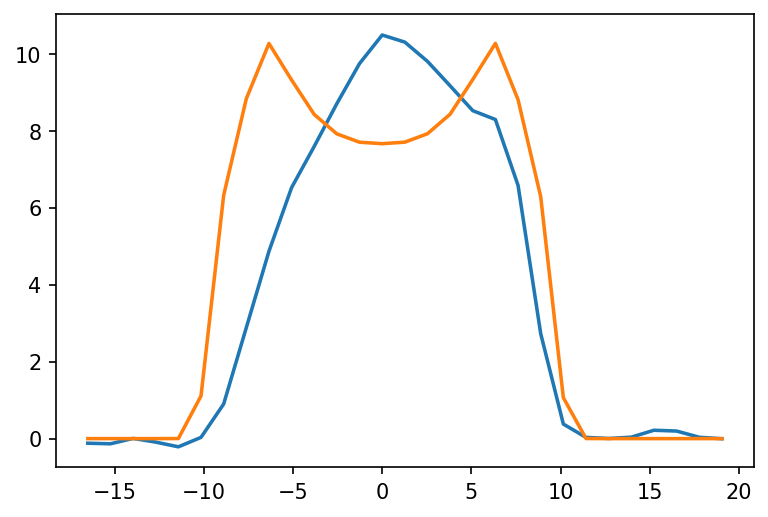

In [15]:
plt.figure(dpi=150)
plt.plot(velos, obs     .sum(axis=(0,1))/70000, linewidth=1.7)
plt.plot(velos, img.data.sum(axis=(0,1)),       linewidth=1.7)

In [16]:
img = fit(loss, model, obs/70000, N_epochs=5, lr=1.0e-1)
loss.renormalise_all()
loss.reset()

  0%|          | 0/5 [00:00<?, ?it/s]

/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 5/5 [00:42<00:00,  8.45s/it]


100%|██████████| 3/3 [00:27<00:00,  9.20s/it]


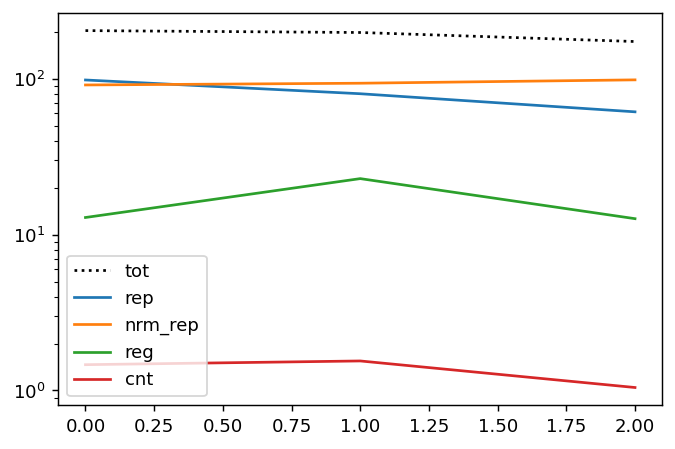

In [17]:
img = fit(loss, model, obs/70000, N_epochs=3, lr=1.0e-1, w_rep=1.0e+2, w_nrm_rep=1.0e+2, w_reg=1.0e+1)
loss.plot()

100%|██████████| 50/50 [07:15<00:00,  8.72s/it]


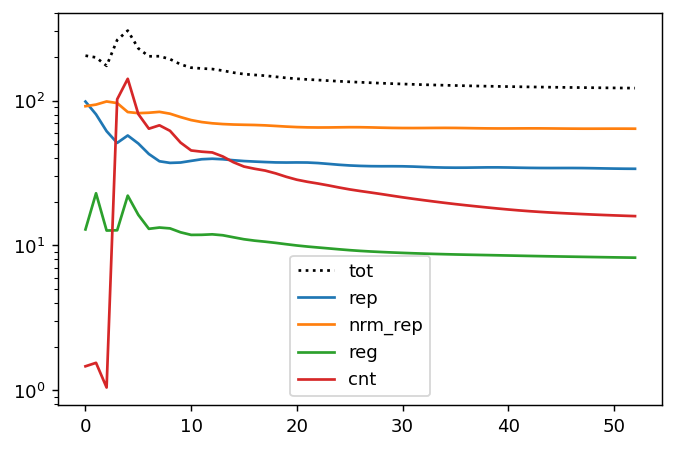

In [18]:
img = fit(loss, model, obs/70000, N_epochs=50, lr=1.0e-1, w_rep=1.0e+2, w_nrm_rep=1.0e+2, w_reg=1.0e+1, w_cnt=1.0e+2)
loss.plot()

100%|██████████| 50/50 [07:14<00:00,  8.69s/it]


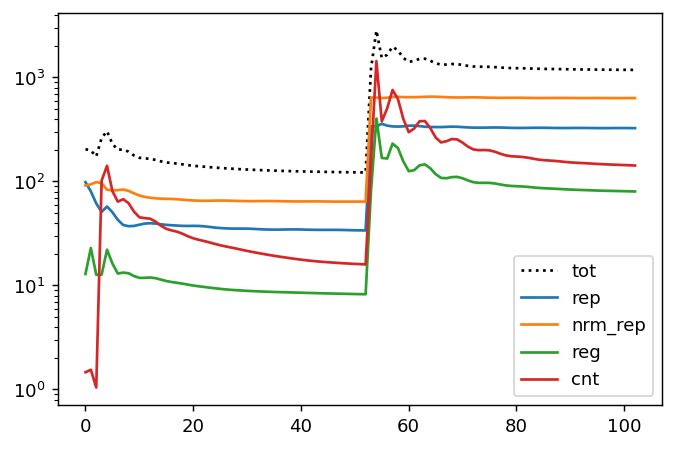

In [19]:
img = fit(loss, model, obs/70000, N_epochs=50, lr=1.0e-1, w_rep=1.0e+3, w_nrm_rep=1.0e+3, w_reg=1.0e+2, w_cnt=1.0e+3)
loss.plot()

In [20]:
model.save('tm_R_Aql_model_1_cont.h5')

In [21]:
model = TensorModel.load('tm_R_Aql_model_1_cont.h5')

In [22]:
plot_cube_2D(model['log_CO'])

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [36]:
print('v_in  =', torch.exp(model['log_v_in' ]).item() / 1.0e+3, 'km/s')
print('v_inf =', torch.exp(model['log_v_inf']).item() / 1.0e+3, 'km/s')
print('T_in  =', torch.exp(model['log_T_in' ]).item(),          'K'   )

v_in  = 0.0007774499762113135 km/s
v_inf = 10.000000000000009 km/s
T_in  = 1396.5817344017178 K


In [37]:
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  beta                       Free          False    +4.795e+00     +4.795e+00     +4.795e+00
  log_CO                     Free          True     +9.885e+00     +1.430e+01     +1.968e+01
  log_T_in                   Free          False    +7.242e+00     +7.242e+00     +7.242e+00
  log_epsilon                Free          False    -2.468e+00     -2.468e+00     -2.468e+00
  log_v_in                   Free          False    -2.517e-01     -2.517e-01     -2.517e-01
  log_v_inf                  Fixed         False    +9.210e+00     +9.210e+00     +9.210e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
sizes: [5.59518907e+14 5.59518907e+14 5.59518907e+14]
shape: (100, 100, 100)


In [38]:
torch.exp(model['log_epsilon'])

tensor(0.0848, dtype=torch.float64, grad_fn=<ExpBackward0>)

In [39]:
img = forward_analytic_velo_and_T(model)

In [40]:
from ipywidgets import interact

def plot(i,j):
    plt.figure(dpi=150)
    plt.plot   (line.freq_to_velo(freqs * units.Hz), obs[i,j,:].data/70000)
    plt.plot   (line.freq_to_velo(freqs * units.Hz), img[i,j,:].data, marker='x')
    # plt.yscale('log')
interact(plot, i=(0, img.shape[0]-1), j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot(i, j)>

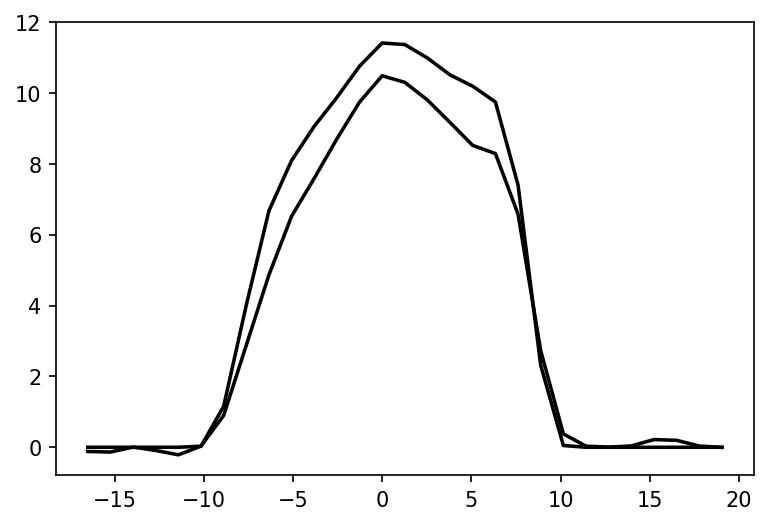

In [41]:
plt.figure(dpi=150)
plt.plot(velos, obs     .sum(axis=(0,1))/70000, c='k', linewidth=1.7)
plt.plot(velos, img.data.sum(axis=(0,1)),      c='k', linewidth=1.7)

In [42]:
rho = model['log_CO']

In [43]:
r   = model.get_radius(origin='centre')      .ravel()
rho = torch.exp(model['log_CO']).data.numpy().ravel()

In [44]:
velocity_r = analytic_velo(
    r     = torch.from_numpy(r),
    r_in  = r.min(),
    v_in  = torch.exp(model['log_v_in']),
    v_inf = torch.exp(model['log_v_inf']),
    beta  =           model['beta']
).data.numpy().ravel()

In [45]:
cte = rho * velocity_r * r**2

/tmp/ipykernel_1135472/3338289136.py:2: RuntimeWarning: divide by zero encountered in true_divide
  dens = np.einsum('ij, i -> ij', dens, 1.0/dens.sum(axis=1))


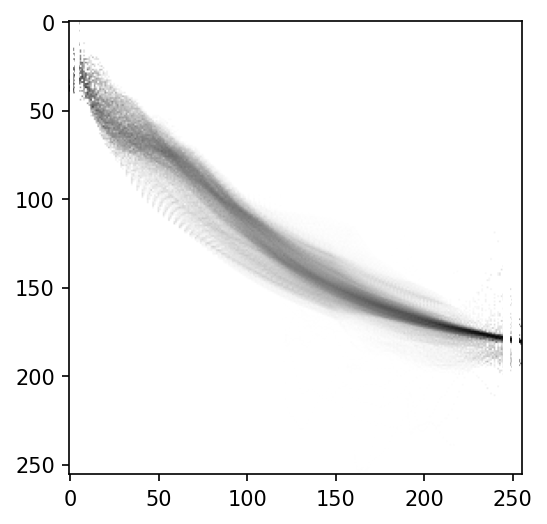

In [46]:
dens = np.histogram2d(r, np.log10(rho), bins=(256,256))[0]
dens = np.einsum('ij, i -> ij', dens, 1.0/dens.sum(axis=1))

plt.figure(dpi=150)
plt.imshow(np.flip(np.log(dens+5.0e-3), axis=1).T, cmap='Greys')

/tmp/ipykernel_1135472/2562534214.py:2: RuntimeWarning: divide by zero encountered in true_divide
  dens = np.einsum('ij, i -> ij', dens, 1.0/dens.sum(axis=1))


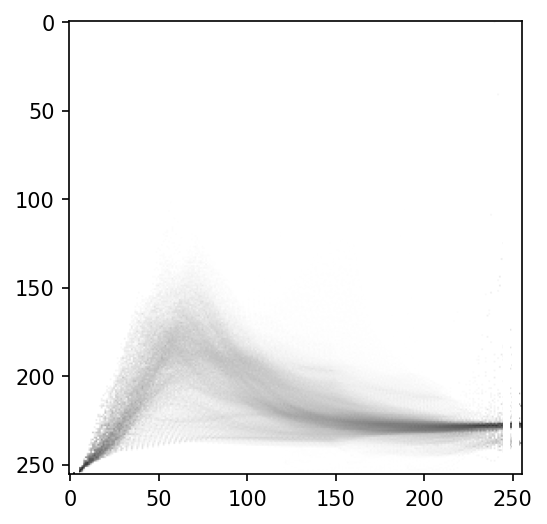

In [47]:
dens = np.histogram2d(r, cte, bins=(256,256))[0]
dens = np.einsum('ij, i -> ij', dens, 1.0/dens.sum(axis=1))

plt.figure(dpi=150)
plt.imshow(np.flip(np.log(dens+5.0e-3), axis=1).T, cmap='Greys')

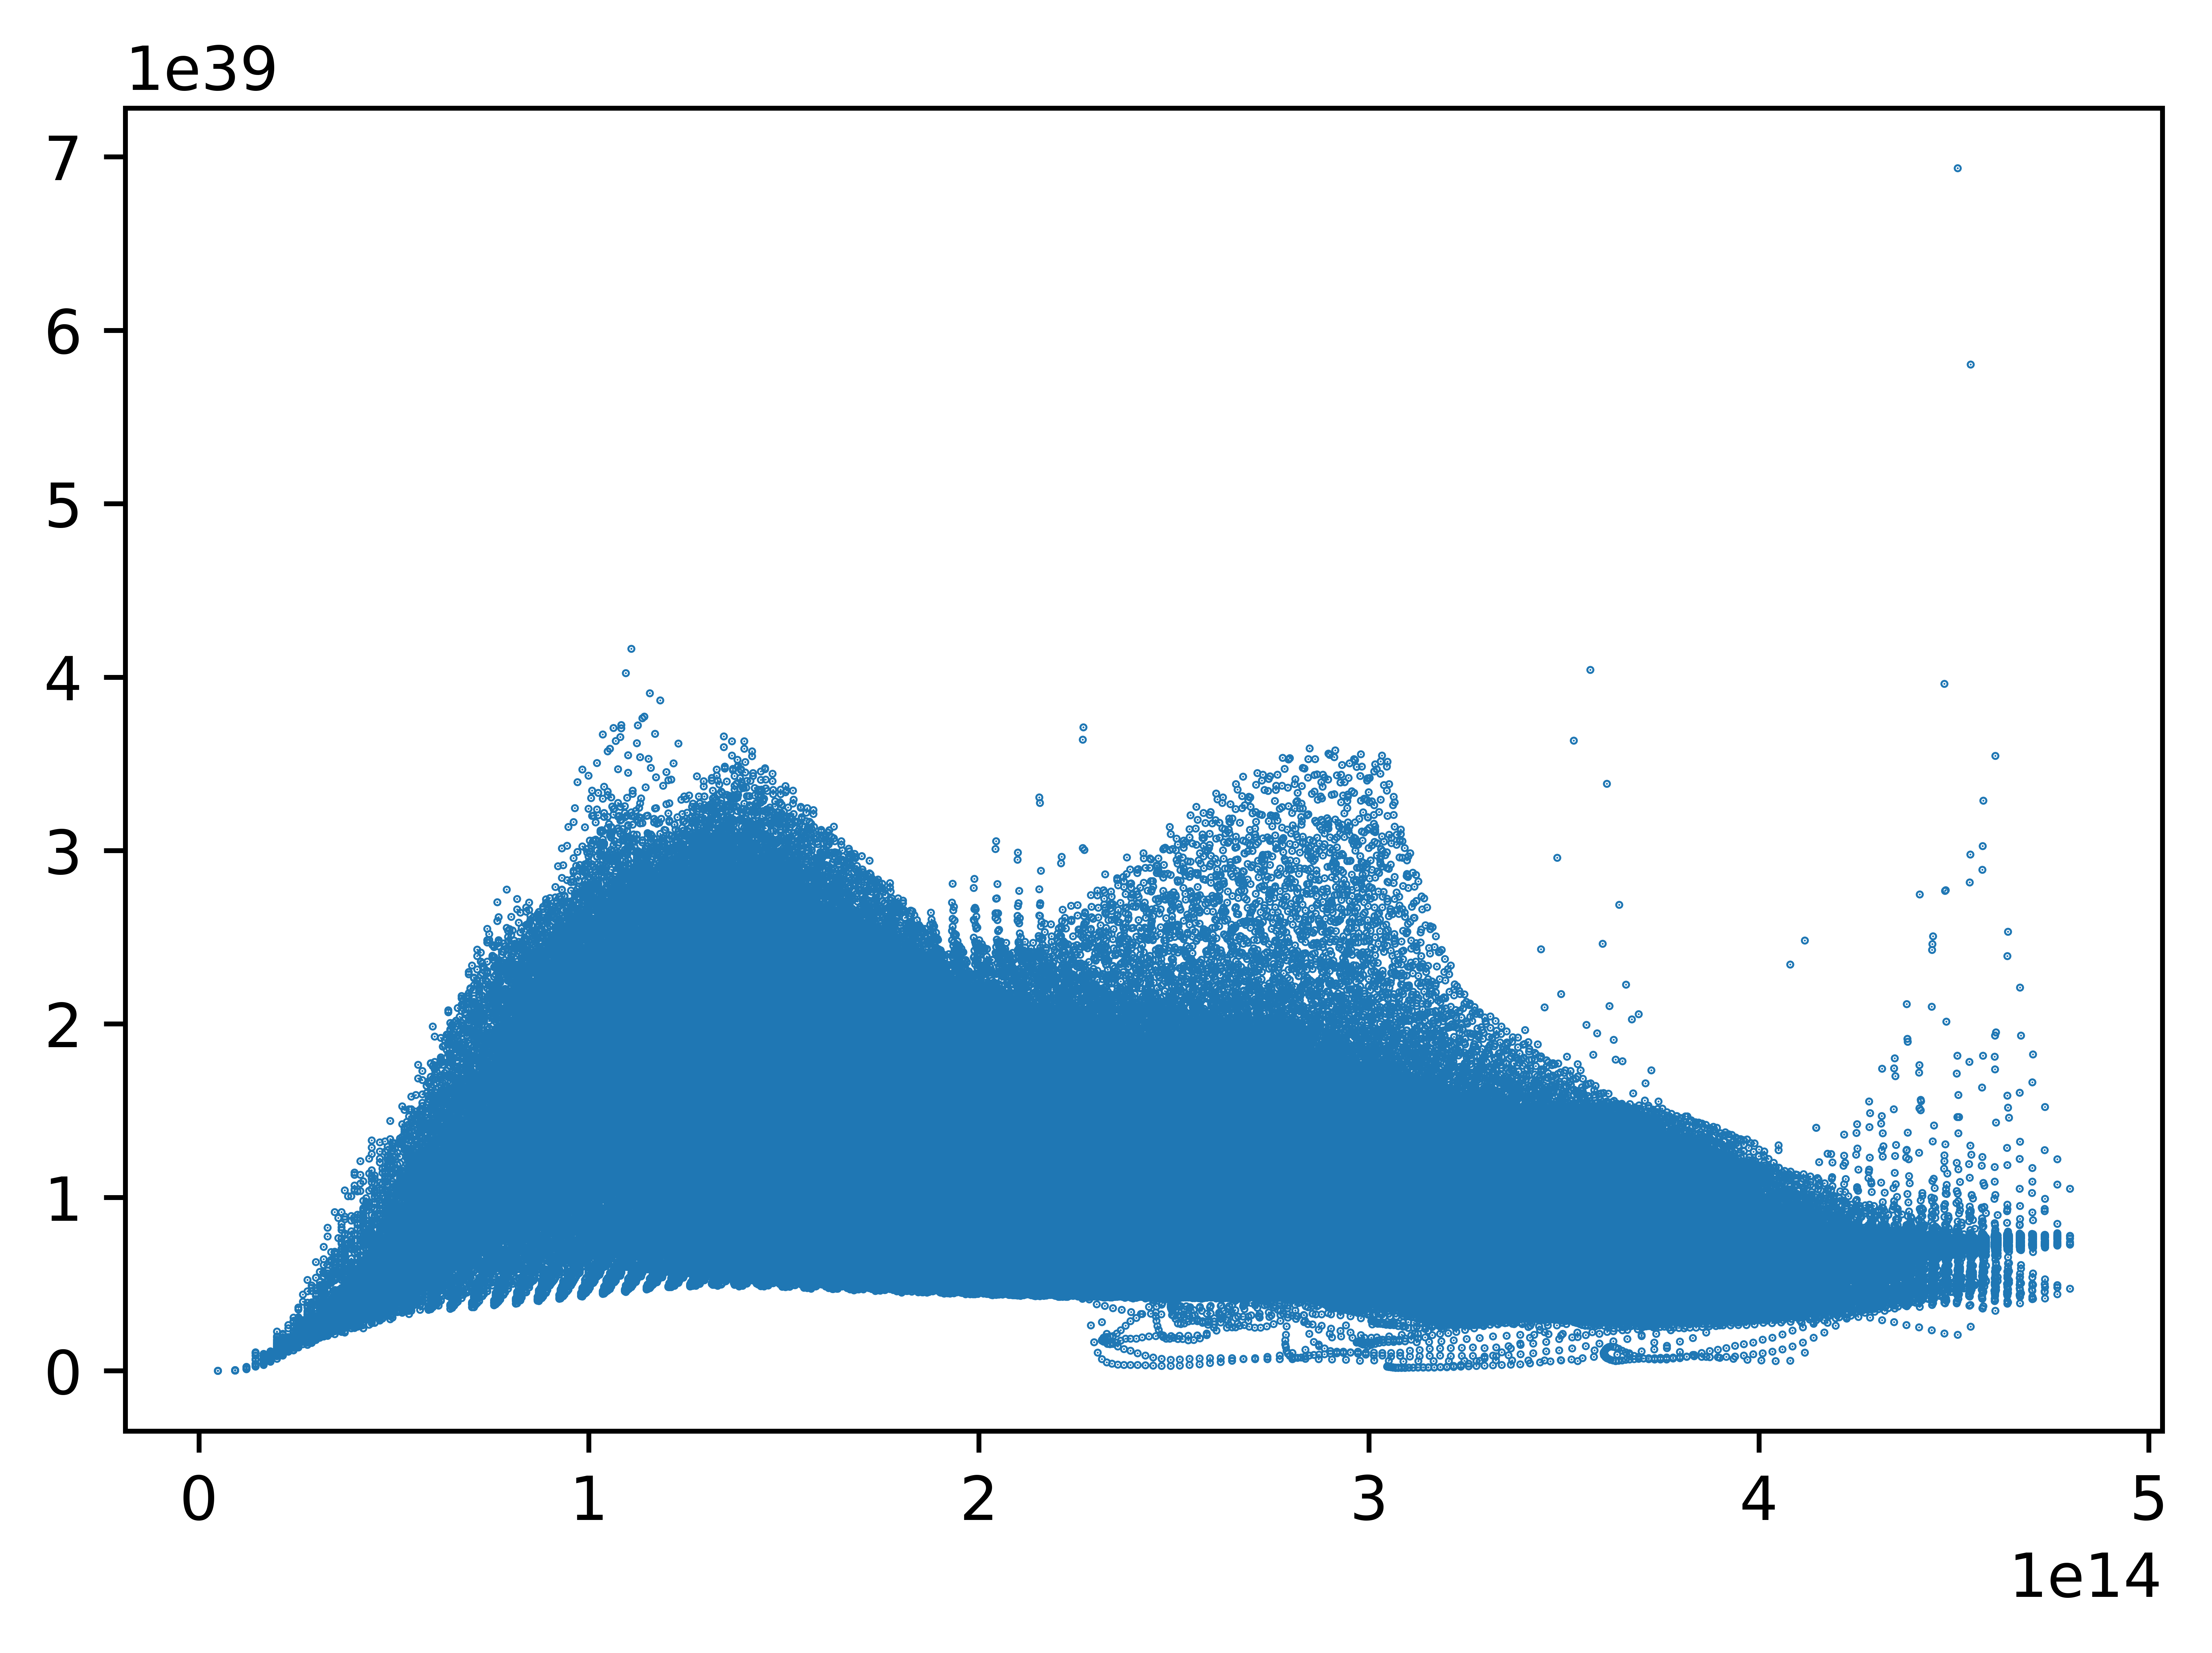

In [48]:
plt.figure(dpi=1350)
plt.scatter(r, cte, s=0.1)
# plt.yscale('log')